In [1]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Specify the path to your dataset ZIP file in Google Drive
zip_file_path = '/content/drive/My Drive/archive.zip'  # Ganti dengan path yang sesuai

# Step 3: Extract the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/covid-pneumonia-normal-chest-xray-images')

# Step 4: Check the extracted files
os.listdir('/content/covid-pneumonia-normal-chest-xray-images')


Mounted at /content/drive


['COVID', 'PNEUMONIA', 'NORMAL']

Found 4183 images belonging to 3 classes.
Found 1045 images belonging to 3 classes.
87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/100
131/131 [==============================] - 188s 1s/step - loss: 0.4643 - accuracy: 0.8152 - val_loss: 0.2531 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 2/100
131/131 [==============================] - 167s 1s/step - loss: 0.2405 - accuracy: 0.9223 - val_loss: 0.1185 - val_accuracy: 0.9656 - lr: 1.0000e-04
Epoch 3/100
131/131 [==============================] - 165s 1s/step - loss: 0.1937 - accuracy: 0.9414 - val_loss: 0.2029 - val_accuracy: 0.9244 - lr: 1.0000e-04
Epoch 4/100
131/131 [==============================] - 163s 1s/step - loss: 0.1543 - accuracy: 0.9534 - val_loss: 0.1801 - val_accuracy: 0.9426 - lr: 1.0000e-04
Epoch 5/100
131/131 [==============================] - 164s 1s/step - loss: 0.1208 - accuracy: 0.9591 - val_loss: 0.1100 - val_accuracy: 0.9675 - lr: 1.0000e-04
Epoch 6/100
131/131 [=========================

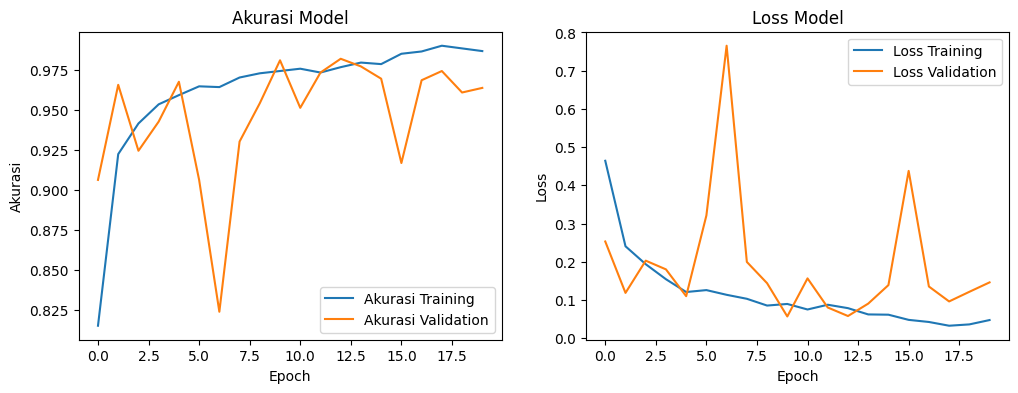

33/33 [==============================] - 6s 165ms/step - loss: 0.0569 - accuracy: 0.9809
Loss pada data validasi: 0.0569
Akurasi pada data validasi: 0.9809


In [2]:

# Define the dataset path after extraction
dataset_path = '/content/covid-pneumonia-normal-chest-xray-images/'

# Parameters
img_size = (224, 224)  # Ukuran input untuk InceptionV3
batch_size = 32
epochs = 100

# Data Augmentation untuk training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,  # Menambahkan flipping vertikal
    fill_mode='nearest',
    validation_split=0.2
)


# Data Augmentation untuk validation set
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # 80% untuk training
)

# Load validation data
validation_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # 20% untuk validation
)

# Load pretrained InceptionV3 tanpa fully connected layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=img_size + (3,))

# Unfreeze beberapa layer terakhir dari base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),        # Pooling layer untuk meratakan fitur
    Dense(256, activation='relu'),   # Fully connected layer dengan 256 neuron
    Dropout(0.5),                    # Dropout untuk mencegah overfitting
    Dense(256, activation='relu'),   # Layer tambahan
    Dropout(0.5),                    # Dropout tambahan
    Dense(3, activation='softmax')   # Output layer (3 classes: COVID, PNEUMONIA, NORMAL)
])

# Compile model dengan learning rate yang lebih rendah untuk fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks: early stopping, model checkpoint, dan reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('inceptionv3_best_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0000001)

# Train model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Save final model as .keras file
model.save('inceptionv3_final_model.keras')

print("Model training selesai dan disimpan sebagai inceptionv3_final_model.keras")

# Plot akurasi dan loss
plt.figure(figsize=(12, 4))

# Plot akurasi training dan validation
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validation')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss training dan validation
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validation')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Loss pada data validasi: {val_loss:.4f}")
print(f"Akurasi pada data validasi: {val_accuracy:.4f}")


In [ ]:
model.save('inceptionv3_best_model.keras')
!zip -r model_inceptionv3.zip inceptionv3_best_model.keras
from google.colab import files
files.download('inceptionv3_best_model.keras')
